In [7]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
                        #    '--xla_dump_to=xla_dump/')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import arviz as az
import jax
import jax.experimental
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel, UniformTSubspace
from src.jax_test_model import MLPModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from jax_tqdm import scan_tqdm
from src.utils import get_cp_w, get_data, get_samples_from_run, get_model_from_run_path

%load_ext autoreload
%autoreload 2

%env XLA_FLAGS

#jax.devices("gpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'--xla_force_host_platform_device_count=10'

In [8]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### Load data

Data shapes: (56, 1) (56,) (33, 1) (33,)


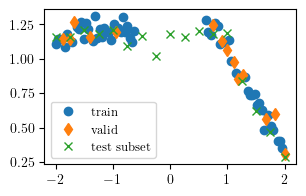

In [9]:
# load data
data = jnp.load('regression_data.npz')
x = jnp.array(data['x'])
y = jnp.array(data['y'])
x_test_ = jnp.array(data['xt'])
y_test_ = jnp.array(data['yt'])
# Split the data into training and validation sets
random_idx = jax.random.choice(random.PRNGKey(0), x.shape[0], (int(x.shape[0]*0.2),), replace=False)
x_val = x[random_idx]
y_val = y[random_idx]
x = x[np.setdiff1d(jnp.arange(x.shape[0]), random_idx)]
y = y[np.setdiff1d(jnp.arange(y.shape[0]), random_idx)]

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

### Define model structure

In [10]:


# config = {
#     'curve_params': {'k': 10,
#                      'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'relu'},
#                      'n_samples': 500,
#                      'lr': 0.001,
#                      'out_scale': 0.05,
#                      'optimize_distparams': True,
#                      'num_epochs': 10000},
#     'sampling': {'space_config': {'space': 'lambda',
#                                   'prior_scale': .5,
#                                   'tube_scale': 1.,
#                                   'prior_correct': False,
#                                   'epsilon': 25.},
#                  'num_chains': 10,
#                  'temperature': 10.,
#                  'num_warmup': 1000,
#                  'num_draws': 1000,
#                  'sampler': 'nuts'},
#     'rng_seed': 0
# }

In [24]:
# define model architecture
model = MLPModel(depth=3, width=16, activation='relu')
model

MLPModel(
    # attributes
    depth = 3
    width = 16
    activation = 'relu'
)

In [25]:
# define the subspace model to optimize the path
k = 10
s_model = SubspaceModel(model, # any model can be passed
                        k,
                        n_samples=10,
                        out_scale=0.05,
                        optimize_distparams=True)

rng_key = random.PRNGKey(0)
rng_key, init_key = random.split(rng_key)
params = s_model.init_params(init_key, x)
params['params']['Dense_0']['kernel'].shape # shape (k+1, 3, 16)

(11, 3, 16)

#### train curve model

100%|██████████| 10000/10000 [00:10<00:00, 985.44it/s]


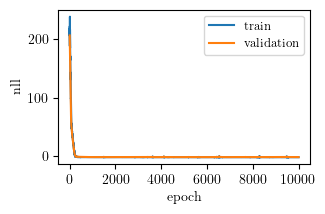

In [26]:
# Train
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

losses = []
val_losses = []
best_val_loss = np.inf
for i in tqdm(range(10000)):
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(
        subkey, params, x, y, opt_state, optimizer)
    # validate
    rng_key, subkey = random.split(rng_key)
    val_loss = s_model.compute_loss(
        subkey, params, x_val, y_val, n_samples=1000)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
    val_losses.append(val_loss)
    losses.append(loss)

plt.plot(losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

(-2.0, -1.0)

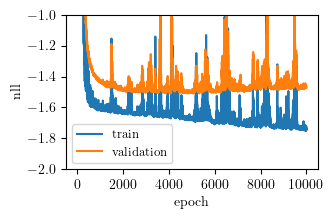

In [29]:
# fast overfitting
plt.plot(losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.ylabel("nll")
plt.xlabel("epoch")
plt.ylim(-2, -1.)

#### functional diversity

Text(0, 0.5, 'y')

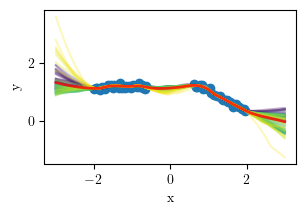

In [35]:
# functional diversity along curve
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(best_params['params'], t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)
plt.xlabel("x")
plt.ylabel("y")

#### Loss Barier along curve

Mean log likelihood: 1.5597097


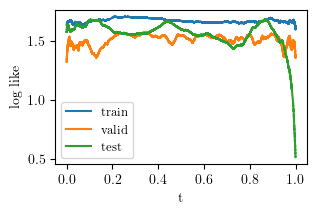

In [36]:
t_space = jnp.linspace(0.0, 1.0, 100000)
nll = s_model.nll(best_params, t_space, x, y).mean(axis=-1)
plt.plot(t_space, -nll, label='train')
nll = s_model.nll(best_params, t_space, x_val, y_val).mean(axis=-1)
plt.plot(t_space, -nll, label='valid')
nll = s_model.nll(best_params, t_space, x_test_, y_test_).mean(axis=-1)
plt.plot(t_space, -nll, label='test')
plt.xlabel("t")
plt.ylabel("log like")
plt.legend()
print("Mean log likelihood:", -nll.mean())

### Run sampling

#### define transformation functions

In [42]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(best_params['params'], k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

Control points in phi space: (11, 10)


In [43]:
from src.jax_test_model import init_t_lambda_to_phi

# initialize RMF Frame
t_lambda_to_phi, curve, d_bezier = init_t_lambda_to_phi(cp_phi,
                                                        k,
                                                        epsilon=25,
                                                        tube_scale=0.1)

tt = jnp.linspace(0., 1., 10_000)
bezier_grad = jax.vmap(d_bezier)(tt)
log_normalized_bezier_grad = jnp.log(jnp.trapezoid(
    jnp.linalg.norm(bezier_grad, axis=-1), tt))

space_at_t0 shape (10, 10)
Stores 26 orthogonal frames  
with ortho frame shape (26, 10, 10)


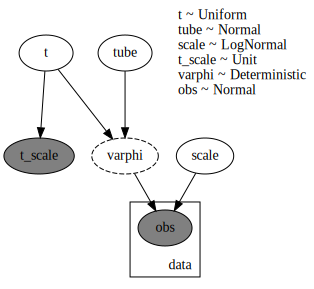

In [47]:
def model_tube(x, y=None, temperature=1.):
    # prior definition
    t = numpyro.sample("t", dist.Uniform(-0.1, 1.1).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(
        0., 0.5).expand((k-1,)).to_event(1))
    scale = numpyro.sample("scale", dist.LogNormal(
            0, 1.))

    # transform tube to space point
    lambda_ = jnp.concat([t, tube], axis=-1)
    space_point = t_lambda_to_phi(lambda_)
    # adjust for different speed
    t_det = jnp.linalg.norm(d_bezier(t), axis=-1)
    numpyro.factor("t_scale", jnp.log(t_det) - log_normalized_bezier_grad)
    # transform space point to weight space
    varphi = numpyro.deterministic('varphi', space_point)
    weight_vec = t_phi_to_weight(varphi)

    # apply model
    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, best_params['params']) # pass params only to define pytree structure
        out = model.apply({'params': weight_pytree}, x)  # uses the model structure from above
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)

    # define likelihood
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), scale+1e-10), obs=y)

numpyro.render_model(model_tube, (x,y), render_distributions=True)

#### run MCLMC sampler using BlackJax

first extract potential fn from numpyro -> then specify balckjax sampler -> run warmup /sampling

In [72]:
from numpyro.infer.util import initialize_model

# get potential_fn for blackjax


# start with sampling -> generate potential_fn for blackjax
rng_key, init_key = jax.random.split(rng_key)
init_params, potential_fn, post_proc_fun, _ = initialize_model(
    init_key,
    # model_tube,
    model_tube,
    model_args=(x, y, 10.),
    # could also set to True => potential_fn_gen(**model_args) instead of potential_fn
    dynamic_args=False,
)

def logdensity_fn(params):
    return -potential_fn(params)

In [73]:
import blackjax
from src.jax_subspace_sampling import setup_inference_chain

num_chains = 10

warmup_fn, run_inference = setup_inference_chain(
    mode="VMAP", num_chains=num_chains)


def init_fn(warmup_key, initial_position, num_warmup):
    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=warmup_key
    )

    # build the kernel
    def kernel(sqrt_diag_cov):
        return blackjax.mcmc.mclmc.build_kernel(
            logdensity_fn=logdensity_fn,
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
            sqrt_diag_cov=sqrt_diag_cov,
        )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_warmup,
        state=initial_state,
        rng_key=warmup_key,
        diagonal_preconditioning=False,
    )
    return blackjax_state_after_tuning, blackjax_mclmc_sampler_params


def get_kernel(parameters):
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=parameters.L,
        step_size=parameters.step_size
    )
    return sampling_alg

In [74]:
rng_key, init_key = jax.random.split(rng_key)
initial_position = {'t': jax.random.uniform(init_key, (num_chains, 1), minval=0., maxval=1.),
                    'tube': jnp.zeros((num_chains, k-1))}
initial_position['scale'] = jnp.full((num_chains,), jnp.exp(best_params['dist_params']['log_scale']))

wall_time, rng_key, last_state, parameters = warmup_fn(rng_key, initial_position, init_fn, num_warmup=1000)
print("Wall time: {:.2f} s".format(wall_time))

Wall time: 7.17 s


In [75]:
wall_time, rng_key, states_phi, infos_phi = run_inference(
    get_kernel, rng_key, last_state, parameters, num_samples=1000)

print("Wall time: {:.2f} s".format(wall_time))

Wall time: 5.51 s


In [76]:
selected_states = jax.tree.map(
    lambda x: x[:, ::10], states_phi.position) # to reduce autocorrelation
selected_states['tube'].shape

(10, 100, 9)

In [77]:
posterior = jax.lax.map(lambda x: jax.vmap(post_proc_fun)(x), selected_states)
samples = az.from_dict(posterior=posterior)
summary = az.summary(samples)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,0.167,0.105,0.036,0.340,0.005,0.003,525.0,646.0,1.01
t[0],0.470,0.357,0.013,0.976,0.050,0.036,75.0,269.0,1.11
tube[0],-0.032,0.401,-0.688,0.779,0.016,0.011,609.0,785.0,1.01
tube[1],-0.061,0.429,-0.873,0.727,0.018,0.013,585.0,892.0,1.01
tube[2],0.020,0.415,-0.710,0.854,0.017,0.012,594.0,713.0,1.01
tube[3],-0.039,0.389,-0.768,0.665,0.016,0.011,577.0,711.0,1.00
tube[4],0.044,0.436,-0.747,0.881,0.018,0.013,573.0,657.0,1.02
tube[5],0.030,0.427,-0.739,0.853,0.018,0.012,594.0,764.0,1.00
tube[6],-0.018,0.457,-0.808,0.867,0.019,0.014,551.0,709.0,1.01
tube[7],-0.020,0.423,-0.813,0.777,0.018,0.013,571.0,757.0,1.01


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

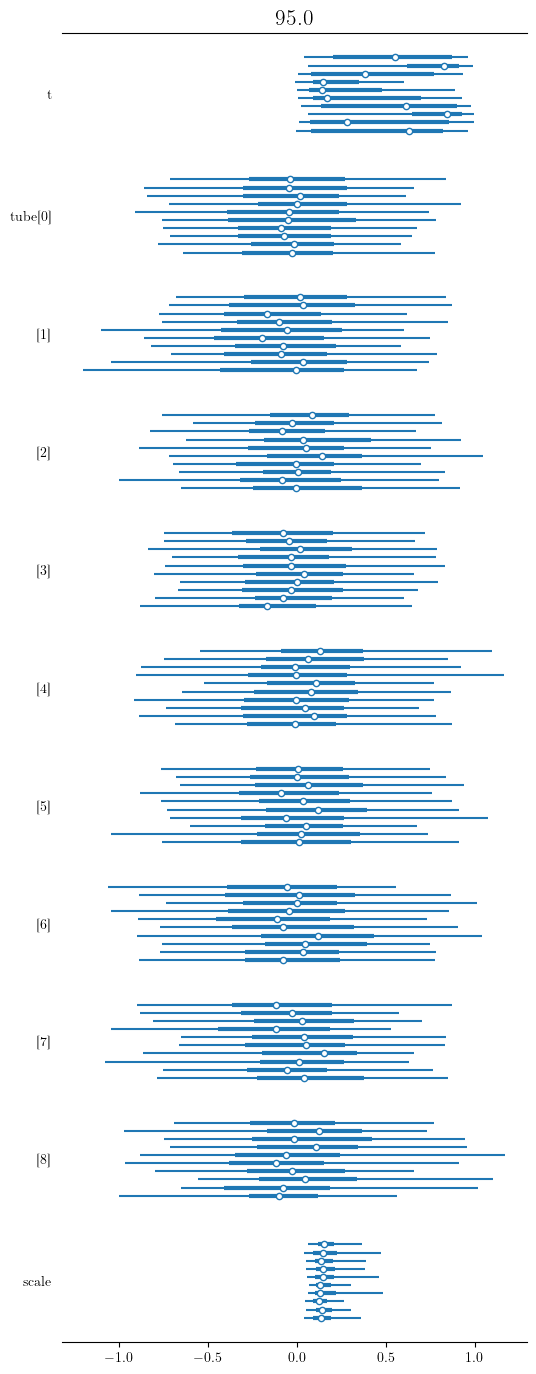

In [82]:
az.plot_forest(samples, var_names=["t", "tube", "scale"], combined=False, hdi_prob=0.95)

In [83]:
def log_like_fn(x, y, posterior):
    def single_log_like_fn(sample):
        with handlers.seed(rng_seed=0):
            cml = handlers.condition(model_tube, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, y, 1.)
            site = ex_trace['obs']
            log_like = site['fn'].log_prob(
                site['value'])
            return log_like
    # return jax.vmap(jax.vmap(single_log_like_fn))(posterior)
    return jax.vmap(lambda sample: jax.lax.map(single_log_like_fn, sample))(posterior)


def prediction(key, x, posterior):
    sample_keys = jax.random.split(key, num_chains)
    def single_prediction_fn(rng_key, sample):
        rng_key, sample_key = random.split(rng_key)
        with handlers.seed(rng_seed=sample_key):
            cml = handlers.condition(model_tube, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return rng_key, site['fn'].sample(sample_key)
    key, preds = jax.vmap(lambda key, sample: jax.lax.scan(
        single_prediction_fn, key, sample))(sample_keys, posterior) # vmap over chains and scan over samples
    return key[-1], preds

In [84]:
log_like = log_like_fn(x_val, y_val, posterior).reshape(-1, len(x_val))
lppd = jnp.mean(jax.scipy.special.logsumexp(
    log_like, axis=0) - jnp.log(log_like.shape[0]))
del log_like
lppd

Array(0.84571105, dtype=float32)

In [85]:
rng_key, preds = prediction(rng_key, x_val, posterior)
rmse = jnp.sqrt(jnp.mean((preds.mean((0, 1)) - y_val) ** 2))
del preds
rmse

Array(0.05328164, dtype=float32)